# How to contruct dot array system  

## 0. Import relevant packages and QuDiPy modules

In [1]:
import os
from pathlib import Path
path = Path(os.getcwd())

# update base working directory to QuDiPy
if path.stem != 'QuDiPy':
    print(path.parents[1])

    base_dir = path.parents[1]
    os.chdir(base_dir)
else:
    base_dir = path

c:\QuDiPy


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from qudipy.system import DotArray
from qudipy.utils import constants

## 1. Generate Dots object instance


### 1.1 Define variables to initialize Dots object instance

Define the directory to  <span style="background-color: Khaki;">store 2D potential slices</span> for all the nextnano simulation data for a given device.

In [3]:
nav_dir = os.path.join('QuDiPy data', 'tutorials')

In [4]:
preprocessed_dir = os.path.join(base_dir, nav_dir,
                            'Pre-processed potentials','2QD_Pre-processed_data')

Define the directory location that contains all of the nextnano simulation  <span style="background-color: Khaki;">data files to be processed or imported</span>.

In [5]:
data_dir = os.path.join(base_dir, nav_dir,
                                    'Nextnano simulations','2QD_dotsep_60nm')

Define a directory to  <span style="background-color: Khaki;">store calculated variables</span> such as $g$-factor deviation, exchange, or potentials for individual dots or dot pairs.

In [6]:
precalculated_dir = os.path.join(base_dir, nav_dir,
                                                'Pre-processed potentials')

Define a list of control names for the contacts of the device simulated in nextnano. 
> **Note**: make sure to label these the same as they are defined in the nextnano input script.

In [7]:
ctrl_names = ['GateContact_T1', 'GateContact_P1', 'GateContact_T2',
                'GateContact_P2', 'GateContact_T3', 
                    'GateContact_S', 'SiContact']   
                
n_dots = 2      # anticipated number of dots

Define control parameters to use when interpolating the potential data from nextnano: must be a subset of the raw data. 
> **Note**: These will greatly influence the accuracy of the resultant calculations as well as the run time of the `Dots()` class upon initial data processing.

In [8]:
pts = [4,3,4]
ctrl_vals = [[0.0], 
    np.linspace(0.2, 0.45, pts[0]),
    np.linspace(-0.1, 0.15, pts[1]),
    np.linspace(0.2, 0.45, pts[2]),
    [0.0], [0.0], [0.0]]


Add a file prefix name to be appended to saved data or interpolation objects that will be computed.

In [9]:
file_prefix = 'tutorial'

### 1.2 Create object instance 

First, instantiate a `Dots()` class object instance using the previously defined variables and choose to calculate the effective parameters ($g$-factor deviation and exchange), or choose just to collect the masked potential interpolation objects (currently these values must be set both to `True`).

If no nextnano data has been saved to the Pre-process directory, then the `save=True` argument must be included. 
This is  <span style="background-color: Khaki;">only needed for the first attempted execution</span>. After the nextnano data has been processed and saved to the Pre-process directory, this flag can be removed.


In [10]:
# Calculate the effective parameters and/or load the masked potential 
# lanscapes as well as save 2D potential slices to Pre-processed directory
dots = DotArray(ctrl_names, ctrl_vals, file_prefix, n_dots=n_dots)
dots.numeric(precalculated_dir, data_dir, preprocessed_dir)

Loading pre-calculated spin interpolators from
c:\QuDiPy\QuDiPy data\tutorials\Pre-processed potentials\tutorial_spin_data_size_[4 3 4]_from_[ 0.2 -0.1  0.2]_to_[0.45 0.15 0.45].pkl


## 1.3 Test dot splitting

The splitting procedure creates a list of new Dots objects. 
They inherit all properties from the parent object _except_:
1. potential interpolator
`dots_object.potential(ctrl_vals)` now outputs masked potential
2. the positions of visible dots __*(counted from 1)*__ may change.

Splitting group can be either `'single'`/`'singles'` (default) for individual dots, 
or `'pair'`/`'pairs'` for adjacent pairs.


> **Note**: if the number of quantum dots decreases for any control value coordinates, then the potential landscape returns `NaN`s, since the quantum dot system must be dot invariant for the present applications. 

> `NaN`s are not displayed when plotting

In [11]:
# Choose voltage control values
voltage_config = [0.2,0.,0.2]

# Quantum dots are not well defined in this case, so NaNs are outputted and 
# are not plotted
# Example voltage configuration:
# voltage_config = [0.2,0.,0.4]

dot1, dot2 = dots.split(group='single')
dotpair1 = dots.split(group='pair')

All Dots objects have the ability to plot the ground state wavefunction
either:

1) Overlayed on the potential

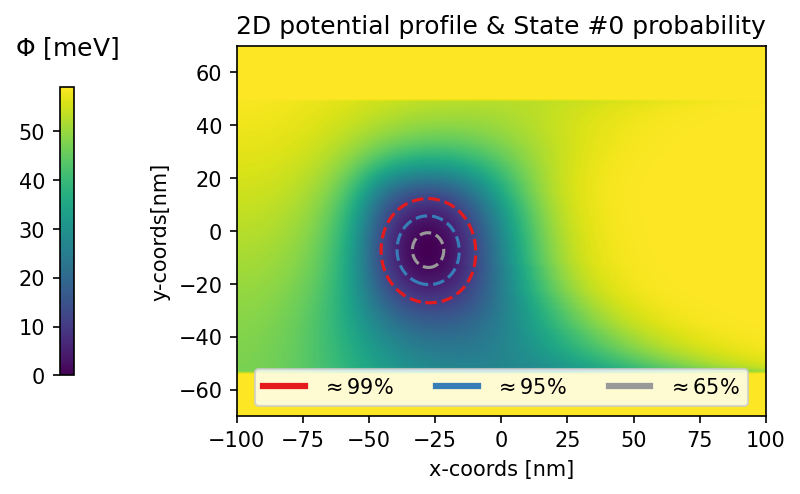

In [12]:
dot1.potential.plot(voltage_config, plot_units=['eV', 'm'], show_wf=True)

2) In a separate subplot figure

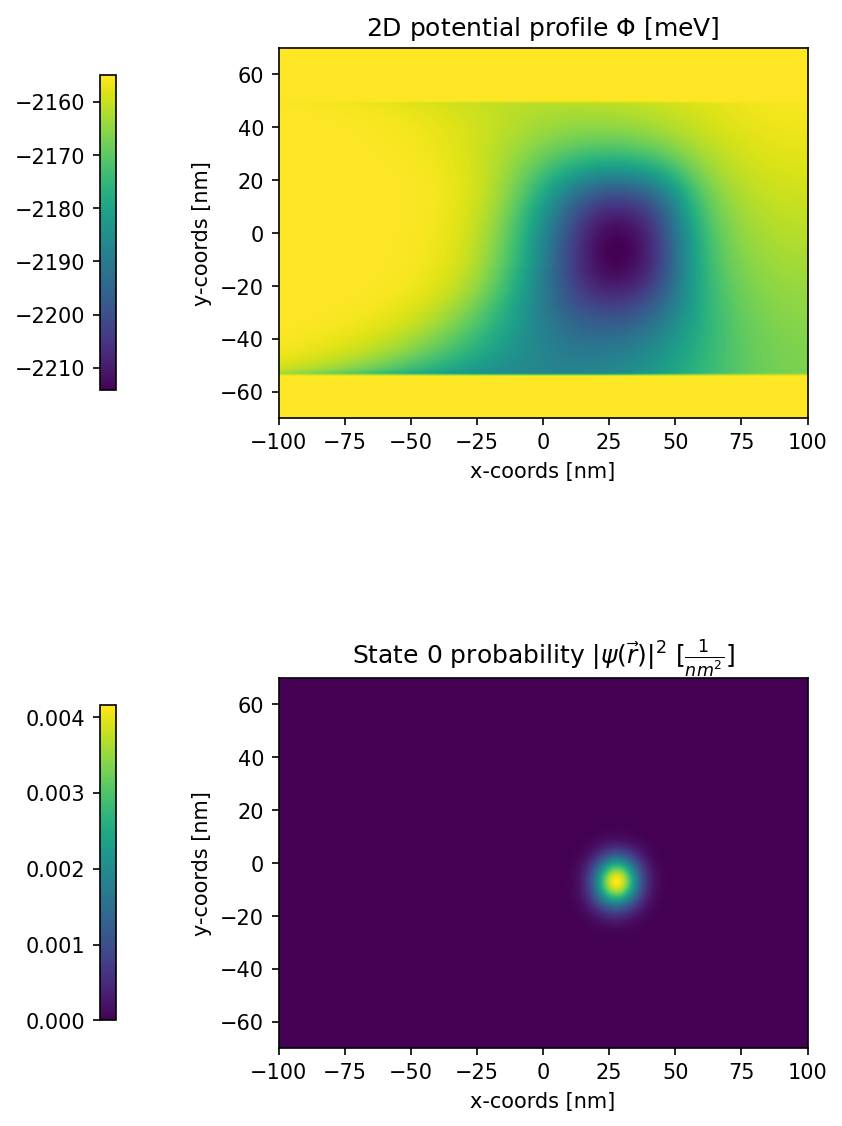

In [13]:
dot2.potential.plot(voltage_config, plot_units=['eV', 'm'], show_wf=True, overlay_ontop=False)

All Dots objects preserve information about the unmasked potential.
They can also be split more than once.

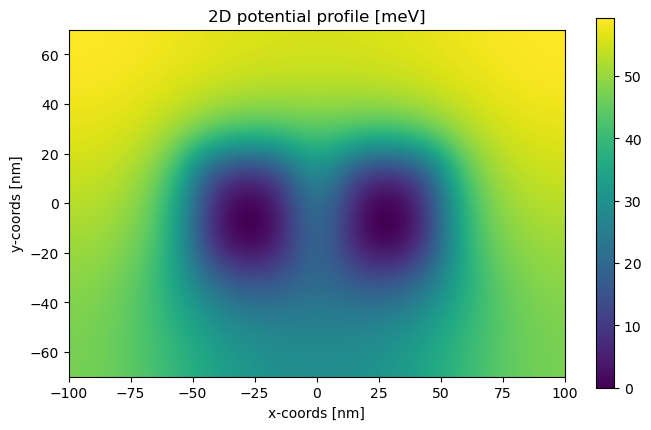

In [14]:
dots.potential.plot(voltage_config, plot_units=['eV', 'm'])

# Try splitting dot1 again
# ddot1, = dot1.split()
# ddot1.potential.plot(voltage_config)

## 1.4 Evaluate effective parameters

For a specific control voltage configuration, the $g$-factor deviations and exchange couplings are determined for each dot or neighboring pair, respectively.

### 1.4.1 g-factor deviation

g-factor deviation for a single voltage vector

In [15]:
voltage_config = [0.2, 0.0, 0.2]

In [16]:
# dots.tunnel_coupling(voltage_config)

In [17]:
# dots.chemical_potential(voltage_config)

In [18]:
# dots.intra_columb(voltage_config)

In [19]:
# dots.inter_columb(voltage_config)

In [20]:
# higher voltage on the 2nd dot gives higher g-factor deviation
voltage_config = [0.2, 0.0, 0.2]

dots.g_factors(voltage_config)

array([1.50602923e-05, 1.50601500e-05])

g-factor deviation for multiple voltage vectors

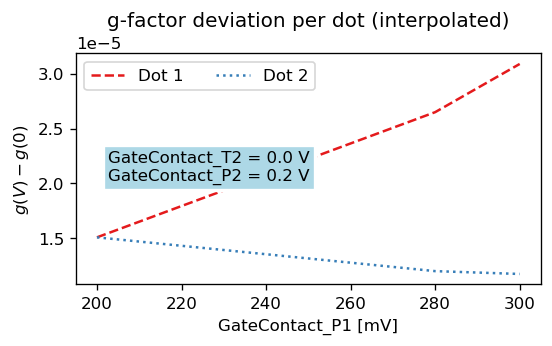

In [21]:
voltage_configs = []
v = np.linspace(0.2, 0.3, 6)
for volt in v:
    voltage_configs.append([volt,0.0,0.2])
    
dots.plot(voltage_configs, param='gfactor')

### 1.4.2 Hund-Mulliken or Heitler-London Exchange

Exchange for a single voltage vector

In [22]:
# HM values are typically larger than HL
ex_hl = dots.exchanges(voltage_config, method='hl')
ex_hm = dots.exchanges(voltage_config, method='hm')

# convert values to neV
print(ex_hl)
print(f'HL exchange: \t {ex_hl[0] / 1.6e-28:.5} neV')
print(f'HM exchange: \t {ex_hm[0] /  1.6e-28:.5} neV')

[3.30317737e-35]
HL exchange: 	 2.0645e-07 neV
HM exchange: 	 5.2434e-11 neV


Exchange for multiple voltage vectors: plotting exchange for a path through voltage state space

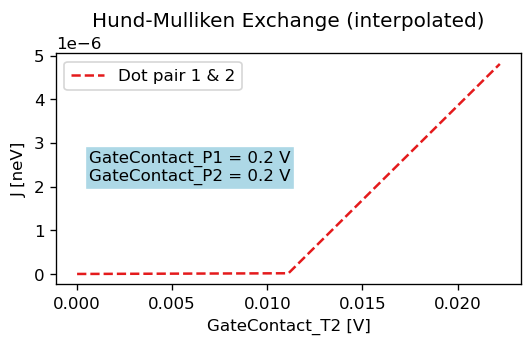

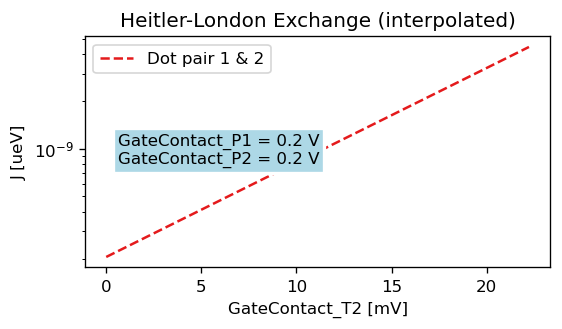

In [23]:
voltage_configs = []
v = np.linspace(0.0,0.1,10)
for volt in v:
    voltage_configs.append([0.2, volt, 0.2])

dots.plot(voltage_configs, param='hm', yscale='linear', plot_units=['eV','n'], axis_units=['V'])
dots.plot(voltage_configs, param='hl', yscale='log', plot_units=['eV','u'], axis_units=['V','m'])